In [1]:
!python3 --version
!pip install import-ipynb
!pip install -U -q PyDrive

Python 3.7.11
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=f7dbb3cf1a42c075bf5485ebeb994e2c20a887dbf0e72a45efaf566b4452ca57
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [2]:
from google.colab import drive; drive.mount('/content/drive')

import pdb
import import_ipynb
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

constants_module = drive.CreateFile({'id':''})
constants_module.GetContentFile('constants.ipynb')

utils_module = drive.CreateFile({'id':''})
utils_module.GetContentFile('utils.ipynb')

Mounted at /content/drive


In [ ]:
from constants import DATA_PATH, TASS_2020_COMMENTS, RANDOM_SEED
from utils import process_regex, process_stopwords, get_stanza_lemmas

In [4]:
import numpy as np
import pandas as pd
import statistics as st

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Seteo seeds solo para reproductibildiad, luego las elimino.

In [5]:
np.random.seed(RANDOM_SEED)

# **Preprocesado**
<p align='justify'>Para emperzar, llevaremos acabo la típica limpieza a la que se somete un corpus de texto: limpiar regex, eliminar algunas stopwords y obtener lemmas.</p>

<p align='justify'>El corpus con el que trabajaré es el corpus TASS 2020. Disponible online en: http://tass.sepln.org/tass_data/download.php.</p>

In [6]:
tass_data = TASS_2020_COMMENTS

In [7]:
print(tass_data.info())
tass_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4802 non-null   int64 
 1   comment    4802 non-null   object
 2   sentiment  4802 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.1+ KB
None


,id,comment,sentiment
0,809927403615256576,En definitiva! Me quedé sin campo para ir a Ta...,N
1,796040775364710400,@dianalaa32 Es una escena de uno de los docume...,P
2,802912779854352384,Qué feo es tener que terminar con alguien; y m...,N
3,800835505717972992,"Oído en McDonalds ""el mejor mannequin challeng...",N
4,791640101751230464,Tengo que aceptar que me esta hundiendo el con...,NEU


<p align='justify'>Dado que trabajaremos con la librería <i>transformers</i> de Hugging Face, y especificamente con la clase <i>Trainer</i>, hay ciertos requisitos que debemos cumplir. Uno de ellos especifica que la columna del dataset que contiene las etiquetas para entrenamiento supervisado debe tener por nombre <i>label</i>. Por lo que en este punto cambiamos el nombre de las columnas (<i>sentiment</i> por <i>label</i>). Además, asignamos valores numéricos a la variable categórica que contiene las etiquetas.</p>

<p align='justify'>Para almacenar toda esta nueva informarción, creamos un nuevo dataframe.</p></br>

Para más información:
  - *https://discuss.huggingface.co/t/key-error-loss-while-fine-tuning-gpt-2-with-the-trainer-utility/2861/4*

In [ ]:
data = pd.DataFrame({"text": [], "label": []})

In [ ]:
tass_data.sentiment = tass_data.sentiment.map({"NEU":0, "N": 1, "P":2})
data.text, data.label = tass_data.comment, tass_data.sentiment
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4802 non-null   object
 1   label   4802 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.5+ KB
None


,text,label
0,En definitiva! Me quedé sin campo para ir a Ta...,1
1,@dianalaa32 Es una escena de uno de los docume...,2
2,Qué feo es tener que terminar con alguien; y m...,1
3,"Oído en McDonalds ""el mejor mannequin challeng...",1
4,Tengo que aceptar que me esta hundiendo el con...,0


<p align='justify'>Utilizamos la función <i>process_regex()</i> para limpiar los comentarios mediante expresiones regualares. Entre las acciones que la función lleva adelante, podemos mencionar: eliminación de palabras repetidas ("holaaaa" por "hola"), eliminación caracteres no alfanuméricos ("$hol//a" por "hola"), normalización de ciertas expresiones ("komo" por "como"), tratado de expresiones argentinas ("re lindo" por "muy lindo"), etc.</p>

In [ ]:
data["text"] = data["text"].apply(process_regex)

In [ ]:
data.head()

,text,label
0,en definitiva me quede sin campo para ir tacar...,1
1,es una escena de uno de los documentales mas r...,2
2,que feo es tener que terminar con alguien mas ...,1
3,oido en mcdonalds el mejor manequin challenge ...,1
4,tengo que aceptar que me esta hundiendo el con...,0


Chequeamos si han quedado valores nulos o strings vacíos luego de aplicar regex:

In [ ]:
print("NaN values positions:", np.where(pd.isnull(data)))
print("Empty strings positions:", np.where(data.applymap(lambda x: x == ' ')))

NaN values positions: (array([], dtype=int64), array([], dtype=int64))
Empty strings positions: (array([], dtype=int64), array([], dtype=int64))


<p align='justify'>Dado que Stanza es basicamente una pipeline de preprocesado, antes de retornar un output, procesa los inputs de diferentes maneras (pos, ner, depparse). Esto hace que, por un lado, genere lemmas en español de muy buena calidad pero, por otro, que sea más lenta (mucho más lenta) que otras librerías con lematizadores, como Spacy. Siendo esto así, una vez generado los lemmas, recomiendo almacernarlos en un csv para no tener que volver a generarlos. Por otra parte, como dato adicional, si es que implementamos la VRAM de la GPU de Colab, la velocidad de generación de lemmas digamos que se "triplica".</p>

<p align='justify'>Me interesa ver cómo el modelo rinde cuando es entrenado con lemmas de Stanza y cuando es entrenado sin lemmas.</p><br/>

Para más información sobre Stanza:
- https://stanfordnlp.github.io/stanza/neural_pipeline.html

In [ ]:
data["lemmas"] = data["text"].apply(get_stanza_lemmas)

<p align='justify'>Por último, voy a adicionar dos columnas: por una lado, una  que contedrá el texto limpio de regex sin stopwords; por otra parte, otra que contendrá los lemmas limpios de regex sin stopwords. De esta manera, vamos a poder probar nuestro modelo basándonos en diferentes estrategias de preprocesado. Para limpiar las stopwords, vamos a utilizar la función <i>process_stopwords()</i>, la cual también nos permite matchear algunas entidades (nombres de personas, ciudades y paises).</p>

In [ ]:
texts = data.text.to_list()

without_stop_entity = []
for t in texts:
  t = process_stopwords(t, match_entities=True, del_entities=True)
  without_stop_entity.append(t)

data["text_withtout_stops"]  = without_stop_entity

In [ ]:
lemmas = data.lemmas.to_list()

without_stop_entity = []
for l in lemmas:
  l = process_stopwords(l, match_entities=True, del_entities=True)
  without_stop_entity.append(l)

data["lemmas_withtout_stops"]  = without_stop_entity

Veamos cómo ha quedado nuestro dataframe final:

In [ ]:
data.head()

,text,label,lemmas,text_withtout_stops,lemmas_withtout_stops
0,en definitiva me quede sin campo para ir tacar...,1,en definitiva yo quedar sin campo para ir taca...,definitiva quede sin campo ir tacares ya habia...,definitiva quedar sin campo ir tacar ya haber ...
1,es una escena de uno de los documentales mas r...,2,ser uno escena de uno de el documental mas res...,es escena documentales mas respetados naturale...,ser escena documental mas respetado naturaleza...
2,que feo es tener que terminar con alguien mas ...,1,que feo ser tener que terminar con alguien mas...,feo es tener terminar alguien mas cuando dos p...,feo ser tener terminar alguien mas cuando dos ...
3,oido en mcdonalds el mejor manequin challenge ...,1,oír en mcdonald el mejor manequin challenge qu...,oido mcdonalds mejor manequin challenge he vis...,oír mcdonald mejor manequin challenge haber ve...
4,tengo que aceptar que me esta hundiendo el con...,0,tener que aceptar que yo este hundir el consum...,tengo aceptar hundiendo consumismo nueva macbo...,tener aceptar hundir consumismo nuevo macbok p...


Guardamos el dataframe que creamos para no tener que volver a generarlo todo desde cero.

In [ ]:
data.to_csv("tass_clean.csv")
!cp tass_clean.csv (DATA_PATH + "/tass_clean.csv")

# **Análisis exploratorio**

Verificamos que los datos no estén desbalanceados y ploteamos un gráfico de barras sencillos para mayor claridad.

Neutral comments: 1523
Negative comments: 1885
Positive comments: 1394
(4802, 5)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


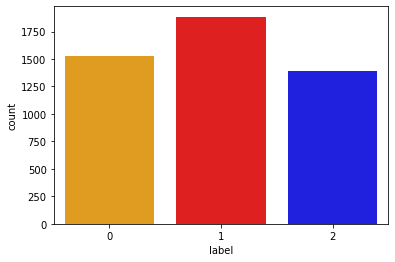

In [ ]:
print("Neutral comments:", len(data[data["label"] == 0]))
print("Negative comments:", len(data[data["label"] == 1]))
print("Positive comments:", len(data[data["label"] == 2]))

print(data.shape)

sns.countplot(data.label, palette=["orange", "red", "blue"])

<p align='justify'><p>Estimamos la media y la desviación estándar de la longitud del conjunto de lemmas preprocesados. En nuestro caso, entendemos por longitud la cantidad de palabras por comentario. Para ello, vamos utilizar las funciones <i>mean()</i> y <i>stdev()</i> de la librería <i>statistics</i>.</p>

In [ ]:
data["text_len"]  = [len(text.split()) for text in data.text]
print("Media:", st.mean(data["text_len"]))
print("Desviación estándar:", st.stdev(data["text_len"]))

Media: 13.951270304039983
Desviación estándar: 6.077959766926607


Si bien, dado todos los comentarios, la media es de 13.95, veamos cómo es que la longitud se distribuye a lo largo de todo el corpus:

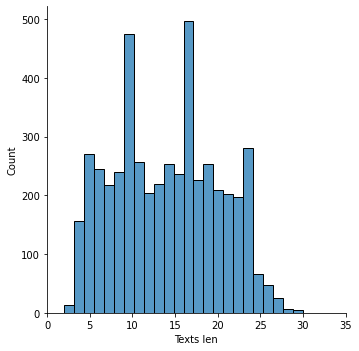

In [ ]:
sns.displot(data["text_len"])
plt.xlim([0, 35])
plt.xlabel("Texts len");

<p align='justify'>El gráfico demuestra que abundan los comentarios más bien cortos, mientras que los comentarios que alcanzan una longitud cercana a 30 palabras son casi nulos. Ahora, si bien lo más probable es que no sea nuestro caso dado que disponemos solo de tres clases balanceadas, me gustaría ver cómo es que la longitud se distribuye a lo largo de cada clase y cerciorarme de que las clases manejan longitudes similares.</p>

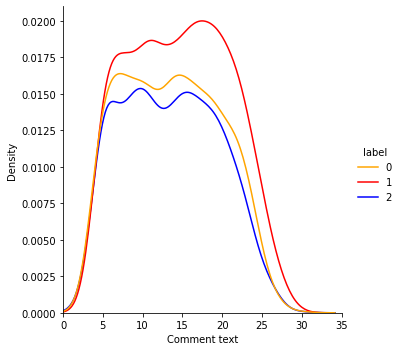

In [ ]:
sns.displot(data, x="text_len", hue="label", kind="kde", palette=["orange", "red", "blue"])
plt.xlim([0, 35])
plt.xlabel("Comment text");

<p align='justify'>Para conveniencia nuestra, podemos ver que este segundo gráfico denota que la longitud de los comentarios positivos es muy similar a la longitud de los comentarios negativos.</p>

<p align='justify'>Siendo esto así, adicionando a la información del primer gráfico de barras, la información presente en este segundo gráfico, notamos que la distribución en cuanto a la longitud de los comentarios se encuentra nomralizada. Podemos optar por tomar una longitud máxima de 30 palabras.</p>

La longitud máxima nos será de utilidad para el entrenamiento del modelo. Más adelante explicaremos porqué.

In [ ]:
MAX_LEN = 30

# **Creación de datasets para entrenamiento, validación y testeo**
<p align='justify'>Dividimos los datos en entrenamiento, validación y testeo, utilizando la función <i>train_test_split()</i> de sklearn. Vamos a realizar diferentes entrenamientos con diferentes porcentajes de datos:</p><br/>

|Train|Eval|Test|
|---|---|---|
|70% |15%|15%|
|80% |10%|10%|
|90% |5%|5%|
|96% |2%|2%|

<br/>

<p align='justify'>La recomendación de Andrew NG (Standford NLP y Google Brain) para cuando se trabaja con datasets grandes es implementar la proporción 99-0.5-0.5, dado que, si nuestro conjunto de datos es grande, un 1% para validación y testeo debería ser suficiente. Sin embargo, para cuando contamos con datasets pequeños o desbalanceados los valores correctos resultan de la propia implementación (prueba y error). De hecho, nuestro dataset no es grande por lo que vamos a realizar diferentes pruebas.</p>

<p align='justify'>Por otra parte, dado que nuestro dataset de entrada está balanceado, vamos a implementar el parámetro <i>stratify</i> en <i>train_test_split()</i> para dividir los datos de manera proporcionada. Si, por ejemplo, hay un 60% de 0s y un 40% de 1s, entonces, al estratificar sobre <i>label</i> (nuestra variable <i>y</i>), nos aseguramos que las muestras aleatorias generadas por la función contengan 60% de 0s y un 40% de 1s. De esta manera, respetamos la distribución original de nuestro dataset de entrada y evitamos el desbalanceo aleatorio, tanto para el entrenamiento, como para la evaluación y el testeo.</p>

**Fuentes:**

*   *https://stats.stackexchange.com/questions/250273/benefits-of-stratified-vs-random-sampling-for-generating-training-data-in-classi/250742#250742*
*   *https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html*

In [ ]:
df_train, df_test = train_test_split(
  data[["text_withtout_stops", "label"]],
  stratify=data.label, 
  test_size=0.04,
  random_state=RANDOM_SEED,
)

df_valid, df_test = train_test_split(
  df_test,
  stratify=df_test.label,
  test_size=0.5,
  random_state=RANDOM_SEED,
)

print(f"train_set: {df_train.shape} \nvalid_set: {df_valid.shape} \ntest_set: {df_test.shape}")
print(f"Total samples: {len(df_train) + len(df_valid) + len(df_test)}")

train_set: (4609, 2) 
valid_set: (96, 2) 
test_set: (97, 2)
Total samples: 4802


In [ ]:
df_train.head()

In [ ]:
df_valid.head()

In [ ]:
df_train.head()